In [1]:
import tensorflow as tf
import keras 
from keras import backend as k
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\MinhThw\OneDrive\Desktop\DATN\data\hyper.csv", sep=";")

In [3]:

df['Hypertension'] = df['Hypertension'].map({'Normal': 0, 'Prehypertension': 1, 'Stage 1 hypertension': 2,'Stage 2 hypertension':3})
df['Sex'] = df['Sex'].map({'Male': 1, 'Female': 0})
df['BMI'] = pd.to_numeric(df['BMI'].str.replace(',', '.'), errors='coerce')
df['Diabetes'] = df['Diabetes'].map(lambda x: 0 if pd.isna(x) else 1)
df['CI'] = df['Cerebral Infarction'].map(lambda x: 0 if pd.isna(x) else 1)
df['CD'] = df['Cerebrovascular Disease'].map(lambda x: 0 if pd.isna(x) else 1)
df['SBP'] = df['Systolic Blood Pressure']
df['DBP'] = df['Diastolic Blood Pressure']
df = df.drop(['Num', 'Subject_ID','Cerebral Infarction', 'Cerebrovascular Disease', 'Diastolic Blood Pressure', 'Systolic Blood Pressure'], axis =1)

In [4]:
df

Sex  Age  Height  Weight  Heart Rate        BMI  Diabetes  Hypertension  \
0      0   45     152      63          97  27.268006         0             3   
1      0   50     157      50          76  20.284799         0             3   
2      0   47     150      47          79  20.888889         0             0   
3      1   45     172      65          87  21.971336         0             1   
4      0   46     155      65          73  27.055151         0             1   
..   ...  ...     ...     ...         ...        ...       ...           ...   
214    1   24     180      70          77  21.604938         0             0   
215    0   25     156      47          79  19.312952         0             0   
216    1   25     176      55          72  17.755682         0             1   
217    1   25     173      63          67  21.049818         0             0   
218    1   24     175      58          65  18.938776         0             0   

     CI  CD  SBP  DBP  
0     0   0  161   89  
1     0   0  160   93  
2     0   0  101   71  
3     0   0  136   93  
4     0   0  123   73  
..   ..  ..  ...  ...  
214   0   0  111   70  
215   0   0   93   57  
216   0   0  120   69  
217   0   0  106   69  
218   0   0  108   68  

[219 rows x 12 columns]

In [5]:
# Chia dữ liệu thành đầu vào (X) và đầu ra (y)
X = df.drop('Hypertension', axis=1)
y = df['Hypertension']


In [6]:
from sklearn.model_selection import train_test_split
# Chia thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(153, 11)
(66, 11)
(153,)
(66,)


In [8]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb

# Định nghĩa lưới tham số
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Tạo đối tượng GridSearchCV
grid_search = GridSearchCV(estimator=xgb.XGBClassifier(eval_metric='logloss'),
                           param_grid=param_grid,
                           scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
                           refit='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# Tạo mô hình mới với tham số tối ưu
best_model = grid_search.best_estimator_

# Đánh giá mô hình bằng cross-validation
cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro'],
                            return_train_score=True)

# In ra kết quả
print("Accuracy trên tập train:")
print(cv_results['train_accuracy'])
print("Accuracy trên tập test:")
print(cv_results['test_accuracy'])
print("F1-score trên tập train:")
print(cv_results['train_f1_macro'])
print("F1-score trên tập test:")
print(cv_results['test_f1_macro'])

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Accuracy trên tập train:
[1. 1. 1. 1. 1.]
Accuracy trên tập test:
[1.         1.         1.         1.         0.96666667]
F1-score trên tập train:
[1. 1. 1. 1. 1.]
F1-score trên tập test:
[1.         1.         1.         1.         0.92222222]


In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, accuracy_score

# Sử dụng cross_val_predict() để dự đoán trên tập test
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Tính toán các metrics
train_accuracy = accuracy_score(y_train, y_pred)
train_f1 = f1_score(y_train, y_pred, average='macro')

print("Accuracy trên tập train:", train_accuracy)
print("F1-score trên tập train:", train_f1)

Accuracy trên tập train: 0.9934640522875817
F1-score trên tập train: 0.9855653568564555


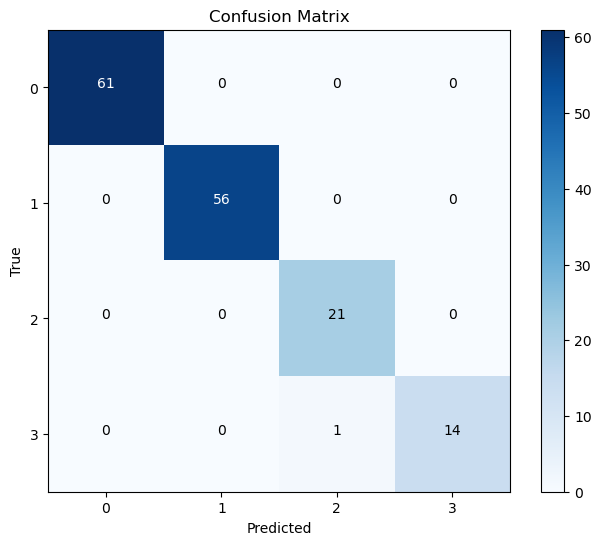

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_train, y_pred)

# Hiển thị số lượng hỗ trợ cho mỗi lớp
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Ghi số lượng vào từng ô của confusion matrix
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
# In classification report
print('Classification Report')
print(classification_report(y_train, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        56
           2       0.95      1.00      0.98        21
           3       1.00      0.93      0.97        15

    accuracy                           0.99       153
   macro avg       0.99      0.98      0.99       153
weighted avg       0.99      0.99      0.99       153



In [25]:

# Sử dụng cross_val_predict() để dự đoán trên tập test
y_pred = cross_val_predict(best_model, X_test, y_test, cv=5)

# Tính toán các metrics trên tập test
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy trên tập test:", test_accuracy)
print("F1-score trên tập test:", test_f1)


Accuracy trên tập test: 0.9393939393939394
F1-score trên tập test: 0.9271216938478312


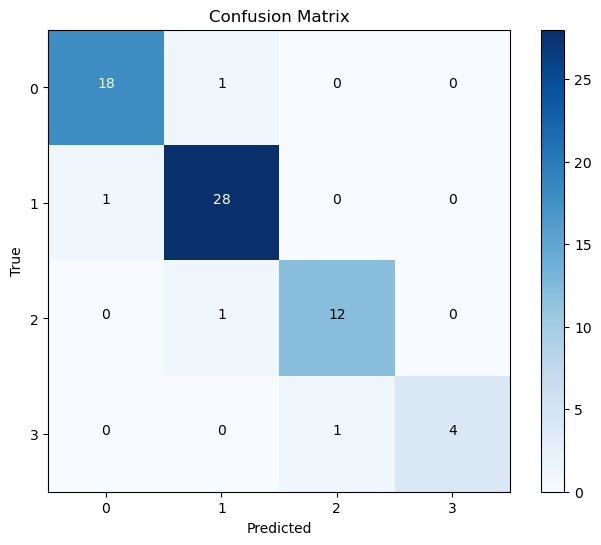

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Hiển thị số lượng hỗ trợ cho mỗi lớp
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()

# Ghi số lượng vào từng ô của confusion matrix
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test))
plt.yticks(tick_marks, np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [29]:
# In classification report
print('Classification Report')
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.93      0.97      0.95        29
           2       0.92      0.92      0.92        13
           3       1.00      0.80      0.89         5

    accuracy                           0.94        66
   macro avg       0.95      0.91      0.93        66
weighted avg       0.94      0.94      0.94        66



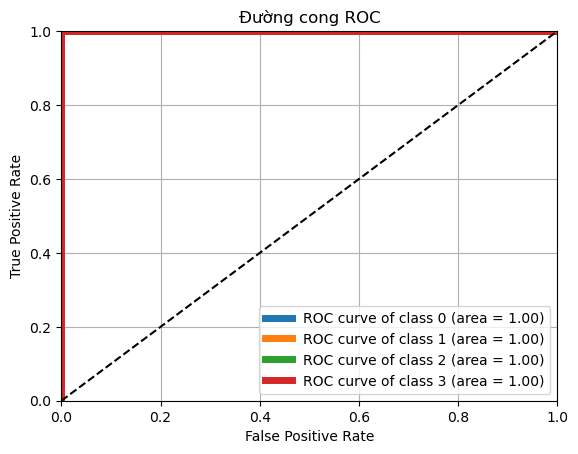

In [15]:
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn đã có mô hình và dữ liệu
# Binarize nhãn thực tế
y_binary = label_binarize(y_test, classes=np.unique(y))  # Chuyển đổi sang định dạng nhị phân
n_classes = y_binary.shape[1]  # Số lượng lớp

# Tính toán xác suất cho tất cả các lớp
y_scores = best_model.predict_proba(X_test)

# Vẽ đường cong ROC cho tất cả các lớp
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binary[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc), linewidth=5)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [16]:
 # In ra báo cáo phân loại cho tập kiểm tra
print("Classification Report for this fold:")
print(classification_report(y_test, y_pred))

Classification Report for this fold:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.93      0.97      0.95        29
           2       0.92      0.92      0.92        13
           3       1.00      0.80      0.89         5

    accuracy                           0.94        66
   macro avg       0.95      0.91      0.93        66
weighted avg       0.94      0.94      0.94        66



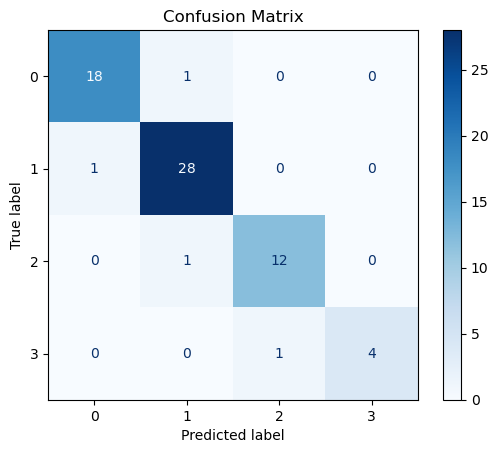

In [17]:
# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [18]:


# Dự đoán trên tập kiểm tra
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [19]:

# In báo cáo phân loại
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        29
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00         5

    accuracy                           1.00        66
   macro avg       1.00      1.00      1.00        66
weighted avg       1.00      1.00      1.00        66



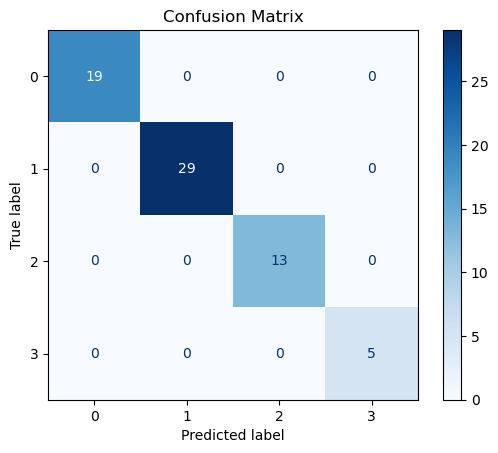

In [20]:
# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

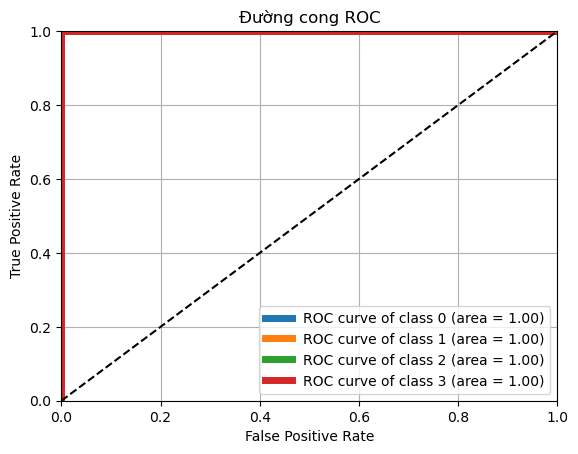

In [21]:
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Giả sử bạn đã có mô hình và dữ liệu
# Binarize nhãn thực tế
y_binary = label_binarize(y_test, classes=np.unique(y))  # Chuyển đổi sang định dạng nhị phân
n_classes = y_binary.shape[1]  # Số lượng lớp

# Tính toán xác suất cho tất cả các lớp
y_scores = best_model.predict_proba(X_test)

# Vẽ đường cong ROC cho tất cả các lớp
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binary[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc), linewidth=5)

plt.plot([0, 1], [0, 1], color='black', linestyle='--')  # Đường chéo
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()